# Project Objective: Market Basket Analysis for Store Layout Optimization

## Objective

The goal of this analysis is to identify product combinations within the Instacart Market Basket dataset using the <b>Apriori algorithm</b>.<br>
Rather than focusing on traditional marketing applications such as cross-selling or bundling, this project aims to explore <b>data-driven store layout optimization</b> based on customer <b>co-purchasing behavior</b>.

## Analytical Focus

By calculating association rules and evaluating the lift metric, the analysis will uncover:

- Product pairs with high lift values (strong co-occurrence)

- Product pairs with low lift values (weak or negative association)

## Strategic Interpretation


| Lift value | Interpretation | Strategic implication |
|-------------|----------------|------------------------|
| **Lift > 4** | Products are frequently purchased together — customers likely buy both regardless of placement | ➡️ **Place these items far apart** to increase store traversal distance and exposure to additional products |
| **Lift ≈ 1** | Neutral association — no significant dependency | ➡️ **Standard placement**, based on category or logistics |
| **Lift < 1** | Products are rarely purchased together — independent or substitute items | ➡️ **Place these items closer together** to encourage impulse buying or cross-category discovery |


## Expected Outcome

The resulting rules will highlight:

- Strongly co-occurring products suitable for separated placement to maximize walking paths.

- Weakly related products suitable for proximity-based placement to stimulate unplanned purchases.

Ultimately, this analysis combines <b>market basket modeling</b> with <b>behavioral retail strategy</b>, illustrating how data science can <b>inform physical store design and customer flow management</b>.

# Exploratory Data Analysis

Before applying the Apriori algorithm, it is essential to explore and understand the dataset.  
The goal of this step is to verify data quality, understand the relationships between tables,  
and gain an initial overview of purchasing patterns.

## Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

## 1. Data Structure & Quality Check 

**Objective:**  
Get an overview of the dataset’s size, data types, and potential data quality issuesicates  

**To do:**- Import datasets
- Inspect shape and columns  
- Check data types  
- Identify missing values  
- Check for duplicates  

### All Orders DataFrame

In [18]:
all_orders = pd.read_csv('all_order_products.csv')

In [19]:
all_orders.head()

,order_id,product_id,add_to_cart_order
0,2,33120,1
1,2,28985,2
2,2,9327,3
3,2,45918,4
4,2,30035,5


In [20]:
all_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 3 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
dtypes: int64(3)
memory usage: 774.1 MB


In [21]:
all_orders.describe(include='all')

,order_id,product_id,add_to_cart_order
count,3.381911e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,2.557551e+04,8.367738e+00
std,9.874008e+05,1.409770e+04,7.139540e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,8.554130e+05,1.351900e+04,3.000000e+00
50%,1.710660e+06,2.525600e+04,6.000000e+00
75%,2.565587e+06,3.793500e+04,1.100000e+01
max,3.421083e+06,4.968800e+04,1.450000e+02


In [22]:
all_orders.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
dtype: int64

In [23]:
all_orders.duplicated().sum()

np.int64(0)

#### Notes / Observations

The <code>all_orders</code> DataFrame contains 33,819,106 rows and 3 columns:<br>
<code>order_id</code>, <code>product_id</code>, and <code>add_to_cart_order</code>.

- <code>order_id</code> appears to represent an order transaction, although it is not unique in this table (each order consists of multiple products).
It will serve as a foreign key when linking to the main <code>orders</code> table.
- <code>product_id</code> represents the purchased product and acts as a foreign key to the <code>products</code> table.
- <code>add_to_cart_order</code> indicates the sequence in which items were added to the cart within each order.
The values range from 1 up to 145, suggesting that some customers purchased up to 145 different items in a single order.

Data quality looks excellent:

- No missing values were found.
- No duplicate rows detected.
- All columns have consistent integer data types.

Statistically, the dataset appears well distributed:

- The average number of items per order (mean of <code>add_to_cart_order</code>) is approximately 8.37,
which aligns with typical grocery shopping behavior.
- The wide standard deviation (~7.14) indicates substantial variation — some orders contain only a few items, while others are large bulk purchases.

In summary, the <code>all_orders</code> dataset provides a clean and transaction-level foundation linking orders and products, which will be essential for building the item association matrix later.

### Orders DataFrame

In [31]:
orders = pd.read_csv('orders.csv')

In [32]:
orders.head()

,order_id,user_id,timestamp
0,2539329,1,2018-01-03 08:00:00
1,2398795,1,2018-01-18 07:00:00
2,473747,1,2018-02-08 12:00:00
3,2254736,1,2018-03-09 07:00:00
4,431534,1,2018-04-06 15:00:00


In [33]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346083 entries, 0 to 3346082
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   order_id   int64 
 1   user_id    int64 
 2   timestamp  object
dtypes: int64(2), object(1)
memory usage: 76.6+ MB


In [34]:
orders['timestamp'] = pd.to_datetime(orders['timestamp'])

In [35]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346083 entries, 0 to 3346082
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   order_id   int64         
 1   user_id    int64         
 2   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 76.6 MB


In [36]:
orders.describe(include='all')

,order_id,user_id,timestamp
count,3.346083e+06,3.346083e+06,3346083
mean,1.710561e+06,1.029778e+05,2018-05-07 04:12:16.914416896
min,1.000000e+00,1.000000e+00,2018-01-01 00:00:00
25%,8.552595e+05,5.139100e+04,2018-02-14 17:00:00
50%,1.710552e+06,1.026750e+05,2018-04-17 14:00:00
75%,2.565877e+06,1.543870e+05,2018-07-13 11:00:00
max,3.421083e+06,2.062090e+05,2019-01-07 23:00:00
std,9.875758e+05,5.953534e+04,NaN


In [37]:
orders.isna().sum()

order_id     0
user_id      0
timestamp    0
dtype: int64

In [38]:
orders.duplicated().sum()

np.int64(0)

#### Notes / Observations

The <code>orders</code> DataFrame contains 3,346,083 rows and 3 columns:<br>
<code>order_id</code>, <code>user_id</code>, and <code>timestamp</code>.

- <code>order_id</code> represents a unique order transaction and serves as the primary key in this table.
- <code>user_id</code> identifies the customer who placed the order and can later be used to analyze user-level purchase behavior.
- <code>timestamp</code> records the date and time of the transaction. <br>
  It has been converted to a <code>datetime64[ns]</code> format to allow for time-based analyses (e.g., trends by hour, day, or month).

Data quality is excellent:

- No missing values were detected.
- No duplicate rows found.
- All columns have consistent and appropriate data types.

Temporal coverage:

- The data spans from January 1, 2018 to January 7, 2019, covering just over one full year of activity.
- This makes it well suited for exploring seasonal or weekly purchasing patterns later in the analysis.

Statistical summary:

- The mean <code>user_id</code> around 102,978 suggests roughly 200 k unique customers (based on the max value).
- The timestamps are well distributed throughout the year, ensuring a balanced dataset for time-based segmentation.

In summary, the <code>orders</code> dataset provides clean and well-structured metadata describing who purchased and when the purchase occurred, forming the temporal and user-level backbone of the market-basket analysis.

### Products DataFrame

In [47]:
products = pd.read_csv('products.csv')

In [48]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [49]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [50]:
products.describe(include='all')

,product_id,product_name,aisle_id,department_id
count,49688.000000,49688,49688.000000,49688.000000
unique,NaN,49688,NaN,NaN
top,NaN,Chocolate Sandwich Cookies,NaN,NaN
freq,NaN,1,NaN,NaN
mean,24844.500000,NaN,67.769582,11.728687
std,14343.834425,NaN,38.316162,5.850410
min,1.000000,NaN,1.000000,1.000000
25%,12422.750000,NaN,35.000000,7.000000
50%,24844.500000,NaN,69.000000,13.000000
75%,37266.250000,NaN,100.000000,17.000000


In [51]:
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [52]:
products.duplicated().sum()

np.int64(0)

#### Notes / Observations

The <code>products</code> DataFrame contains 49,688 rows and 4 columns:<br>
<code>product_id</code>, <code>product_name</code>, <code>aisle_id</code>, and <code>department_id</code>.

- <code>product_id</code> serves as the primary key, uniquely identifying each product sold by the store.
- <code>product_name</code> represents the name of each product. All names are unique, and no missing values are present — confirming that the dataset covers 49,688 distinct products.
- <code>aisle_id</code> represents the shelf or section within a department where the product is located.
The values range from 1 to 134, indicating 134 different aisles or shelf categories in total.
- <code>department_id</code> represents the main department of the store, with values ranging from 1 to 21, suggesting 21 unique departments overall.

Data quality is excellent:

- No missing values detected in any column.
- No duplicate rows found.
- Consistent data types across all columns (int64 and object).

Descriptive statistics show a well-balanced distribution of products across aisles and departments.<br>
The dataset thus provides a clear hierarchical mapping from department → aisle → product,
which will be essential later when analyzing cross-department or cross-aisle relationships using the Apriori algorithm.

In summary, the <code>products</code> dataset offers a comprehensive and clean inventory reference that connects product-level data to both shelf and department structures — forming the categorical backbone of the entire analysis.

## 2. Key Relationships Validation

In [60]:
missing_orders = all_orders[~all_orders['order_id'].isin(orders['order_id'])]
missing_products = all_orders[~all_orders['product_id'].isin(products['product_id'])]
print(len(missing_orders), "orders missing")
print(len(missing_products), "products missing")

0 orders missing
0 products missing


### Notes / Observations

All key relationships are consistent across the datasets:

- Every <code>order_id</code> in the <code>all_orders</code> DataFrame exists in the orders table.
- Every <code>product_id</code> in the <code>all_orders</code> DataFrame exists in the products table.

No missing or mismatched keys were found, meaning the datasets can be safely merged without any data loss or integrity issues.

## 3. General Overview

In [64]:
print("Unique users:", orders['user_id'].nunique())
print("Unique orders:", orders['order_id'].nunique())
print("Unique products:", products['product_id'].nunique())

Unique users: 206209
Unique orders: 3346083
Unique products: 49688


In [65]:
user_num_orders = orders.groupby('user_id')['order_id'].count()
user_num_orders.nlargest(n=10)

user_id
210     100
310     100
313     100
690     100
786     100
1024    100
1428    100
1683    100
1958    100
2405    100
Name: order_id, dtype: int64

In [66]:
user_num_orders.describe()

count    206209.000000
mean         16.226658
std          16.662238
min           3.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_id, dtype: float64

In [67]:
order_sizes = all_orders.groupby('order_id')['product_id'].count()
order_sizes.describe()

count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64

In [68]:
products['department_id'].value_counts().head(21)

department_id
11    6563
19    6264
13    5371
7     4365
1     4007
16    3449
17    3085
15    2092
9     1858
4     1684
3     1516
20    1322
21    1258
6     1139
14    1115
18    1081
5     1054
8      972
12     907
2      548
10      38
Name: count, dtype: int64

In [69]:
products['aisle_id'].value_counts().head(10)

aisle_id
100    1258
45     1246
37     1091
47     1038
120    1026
107     989
94      894
21      891
38      880
61      874
Name: count, dtype: int64

### Notes / Observations

Across all merged DataFrames, the dataset contains:

- 206,209 unique users
- 3,346,083 unique orders
- 49,688 unique products

On average, each order contains about 10 products (mean ~10.1), with a median of 8 items per order.<br>
However, the standard deviation of 7.54 and a maximum of 145 indicate that some orders are significantly larger — typical for bulk or weekly shopping trips.

Each customer placed between 3 and 100 orders, with an average of ~16.2 orders per user.<br>
The distribution is quite spread out (std ≈ 16.7), suggesting that while most users purchase occasionally, a small subset of high-frequency customers place the maximum of 100 orders — likely loyal or heavy users. This variability in purchase frequency could later influence item co-occurrence patterns in the Apriori analysis.

Department-wise, the assortment is unevenly distributed:

- Department 11 and Department 19 contain the most products (~6,500 and 6,200 respectively), suggesting broad product categories such as “Pantry” or “Produce.”
- Department 10 is the smallest, with only 38 products.

The largest aisle (<code>aisle_id</code> 100) includes 1,258 unique products, followed closely by aisles 45 and 37, each exceeding 1,000 products.<br>
This suggests that some aisles are highly diversified, possibly representing major sections such as beverages or snacks.

## 4. Time-based Exploration

In [77]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [78]:
orders['hour'] = orders['timestamp'].dt.hour
orders['day_of_week'] = orders['timestamp'].dt.day_name()
orders['month'] = orders['timestamp'].dt.month
orders['season'] = orders['month'].apply(get_season)

In [79]:
orders.head()

,order_id,user_id,timestamp,hour,day_of_week,month,season
0,2539329,1,2018-01-03 08:00:00,8,Wednesday,1,Winter
1,2398795,1,2018-01-18 07:00:00,7,Thursday,1,Winter
2,473747,1,2018-02-08 12:00:00,12,Thursday,2,Winter
3,2254736,1,2018-03-09 07:00:00,7,Friday,3,Spring
4,431534,1,2018-04-06 15:00:00,15,Friday,4,Spring


### Seasonal/Weekdays

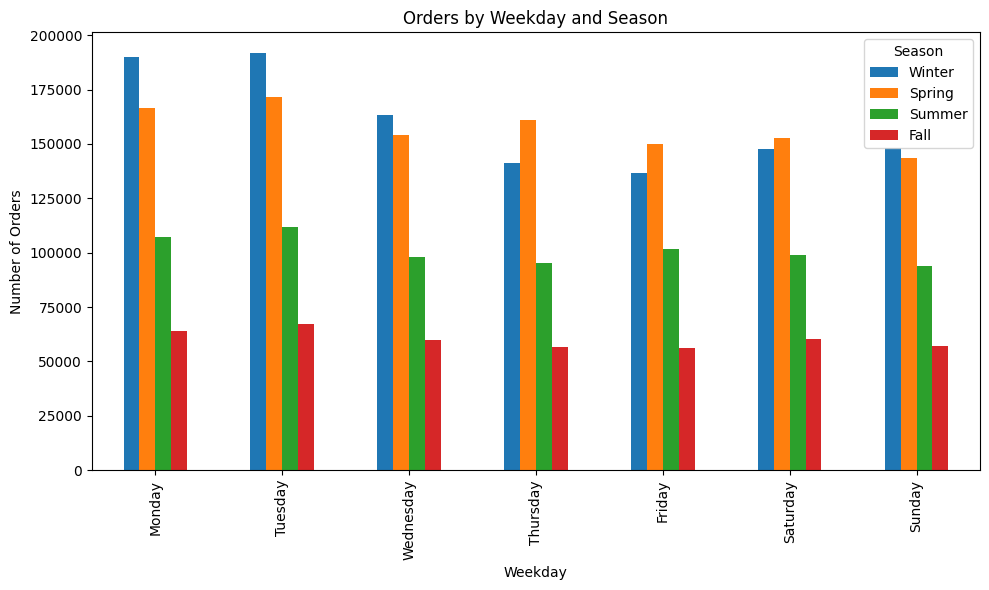

In [81]:
# 1) Fix weekday order (Mon → Sun)
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
orders["day_of_week"] = orders["day_of_week"].astype(
    CategoricalDtype(categories=dow_order, ordered=True)
)

# 2) Optional: fix season order
season_order = ["Winter", "Spring", "Summer", "Fall"]
orders["season"] = orders["season"].astype(
    CategoricalDtype(categories=season_order, ordered=True)
)

# 3) Aggregate to a 7 × 4 table
season_week_counts = (
    orders.groupby(["day_of_week", "season"], observed=True)
          .size()
          .unstack("season")
          .reindex(dow_order)
          .fillna(0)
)

# 4) Plot grouped bar chart (matplotlib picks distinct colors automatically)
ax = season_week_counts.plot(kind="bar", figsize=(10,6))
ax.set_title("Orders by Weekday and Season")
ax.set_xlabel("Weekday")
ax.set_ylabel("Number of Orders")
ax.legend(title="Season")
plt.tight_layout()
plt.show()

### Orders per Day

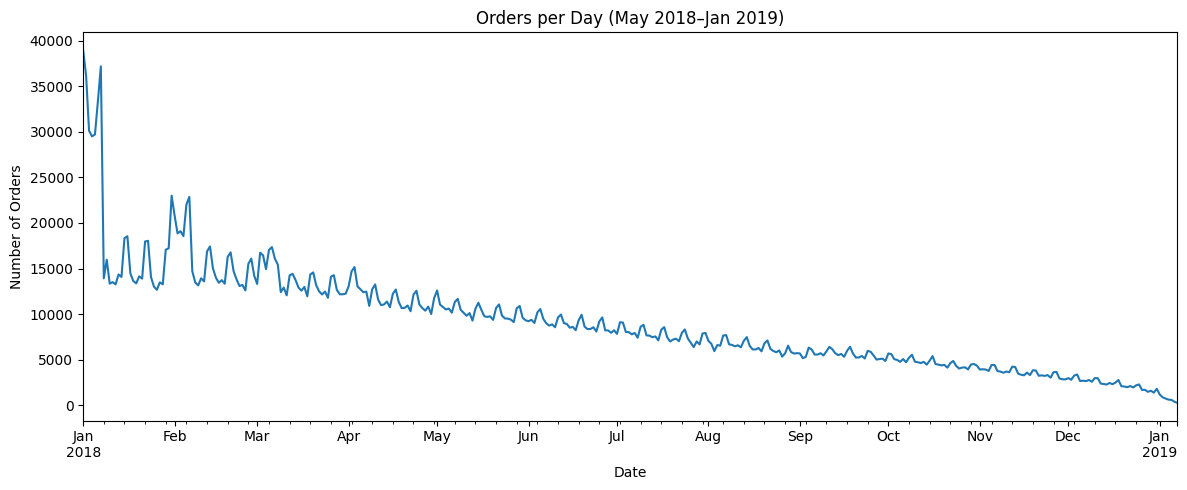

In [83]:
orders_per_day = (
    orders.set_index('timestamp')
          .resample('D')['order_id']
          .count()
)

orders_per_day.plot(figsize=(12,5), title="Orders per Day (May 2018–Jan 2019)")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


### User Dynamic per Month

In [85]:
orders['month_n'] = orders['timestamp'].dt.to_period('M')

user_activity = orders.groupby('user_id')['timestamp'].agg(['min','max'])
user_activity['first_month'] = user_activity['min'].dt.to_period('M')
user_activity['last_month']  = user_activity['max'].dt.to_period('M')

new_users_per_month = user_activity['first_month'].value_counts().sort_index()

active_users_per_month = (
    orders.groupby('month_n')['user_id'].nunique()
)

last_orders_per_month = user_activity['last_month'].value_counts().sort_index()

user_dynamics = pd.DataFrame({
    'new_users': new_users_per_month,
    'active_users': active_users_per_month,
    'last_orders': last_orders_per_month
}).fillna(0).astype(int)

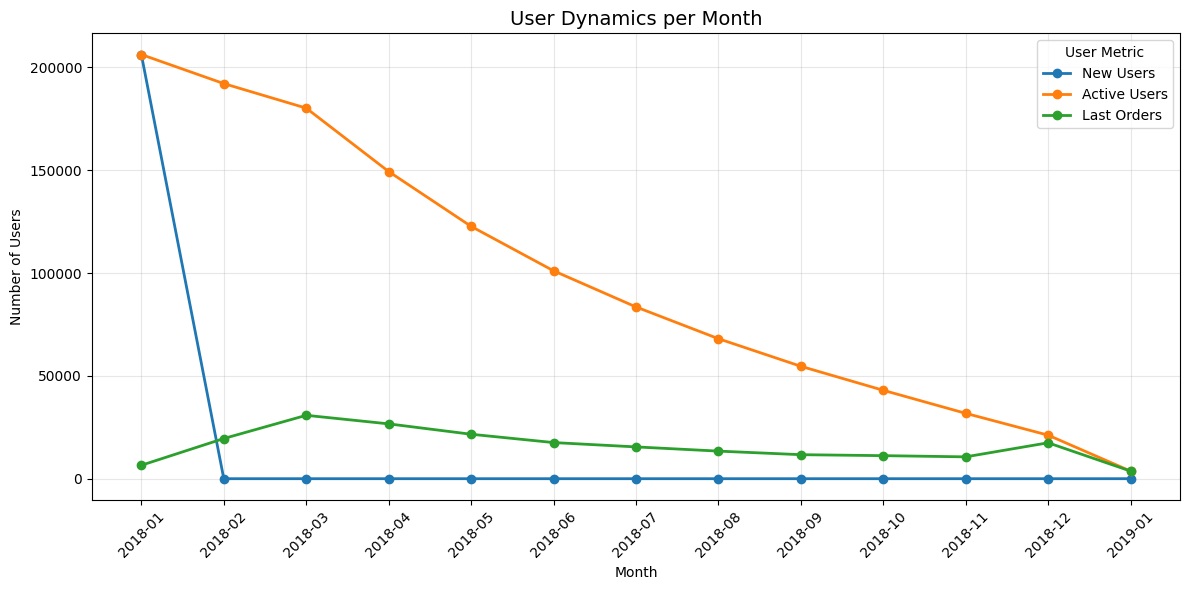

In [86]:
plt.figure(figsize=(12,6))
plt.plot(user_dynamics.index.astype(str), user_dynamics['new_users'], 
         marker='o', label='New Users', linewidth=2)
plt.plot(user_dynamics.index.astype(str), user_dynamics['active_users'], 
         marker='o', label='Active Users', linewidth=2)
plt.plot(user_dynamics.index.astype(str), user_dynamics['last_orders'], 
         marker='o', label='Last Orders', linewidth=2)

plt.title("User Dynamics per Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.legend(title="User Metric")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [87]:
user_dynamics.head(13)  

,new_users,active_users,last_orders
2018-01,206209,206209,6529
2018-02,0,192090,19526
2018-03,0,180154,30815
2018-04,0,149339,26655
2018-05,0,122684,21607
2018-06,0,101077,17563
2018-07,0,83514,15454
2018-08,0,68060,13409
2018-09,0,54651,11673
2018-10,0,42978,11200


### Notes / Observations

The initial time-based exploration, segmented by seasons, suggested a strong decline in order volume during summer and fall.<br>
To verify this, the total number of orders per day was plotted across the entire dataset timeframe (January 2018 – January 2019).<br>
The results revealed a steady and continuous decline in daily orders throughout the year, contradicting the earlier assumption of seasonal behavior.

To investigate the cause of this decline, a monthly user dynamics analysis was conducted — tracking new users, active users, and users placing their final order.<br>
The findings clearly show that:

- A single, large cohort of 206,209 users was registered at the start of January 2018.
- No new users were added afterwards.
- The number of active users steadily decreased each month, while the count of users placing their last order gradually increased.
- Each user placed a maximum of 100 orders, suggesting a system-imposed limit or an experimental dataset constraint.

This pattern indicates that the dataset likely originates from a planned test or controlled cohort, rather than an ongoing retail operation with continuous user growth.<br>
The overall decline in order volume is therefore explained by user attrition and capped participation, rather than genuine market or seasonal effects.

## 5. Product Popularity & Distribution

In [94]:
orders_products = pd.merge(
    all_orders,
    products[['product_id', 'product_name', 'aisle_id', 'department_id']],
    on='product_id',
    how='left'
)

In [95]:
orders_products.head(1)

,order_id,product_id,add_to_cart_order,product_name,aisle_id,department_id
0,2,33120,1,Organic Egg Whites,86,16


In [96]:
top_products_dept = (
    orders_products.groupby(['department_id', 'product_name'])
    .size()
    .reset_index(name='order_count')
    .sort_values('order_count', ascending=False)
)

In [97]:
top_products_dept.nlargest(n=20, columns='order_count')

,department_id,product_name,order_count
6190,4,Banana,491291
6184,4,Bag of Organic Bananas,394930
7252,4,Organic Strawberries,275577
6916,4,Organic Baby Spinach,251705
7063,4,Organic Hass Avocado,220877
6902,4,Organic Avocado,184224
6742,4,Large Lemon,160792
7581,4,Strawberries,149445
6767,4,Limes,146660
35476,16,Organic Whole Milk,142813


In [98]:
top_products_dept['rank'] = (
    top_products_dept.groupby('department_id')['order_count']
    .rank(method='first', ascending=False)
)

top3_per_dept = (
    top_products_dept
    .query('rank <= 3')
    .sort_values(['department_id', 'rank'], ascending=[True, True])
    .reset_index(drop=True)
)

In [99]:
pd.set_option('display.max_rows', 200)
top3_per_dept.head(63)

,department_id,product_name,order_count,rank
0,1,Blueberries,58269,1.0
1,1,Organic Broccoli Florets,34248,2.0
2,1,Organic Whole Strawberries,32658,3.0
3,2,Roasted Almond Butter,4150,1.0
4,2,Light CocoWhip! Coconut Whipped Topping,1622,2.0
5,2,93/7 Ground Beef,1358,3.0
6,3,100% Whole Wheat Bread,63114,1.0
7,3,Organic Bread with 21 Whole Grains,23944,2.0
8,3,Ezekiel 4:9 Bread Organic Sprouted Whole Grain,18487,3.0
9,4,Banana,491291,1.0


### Notes / Observations

After merging the <code>all_orders</code> DataFrame with the <code>products</code> table, product names and department information were added to enable a detailed view of item popularity across the entire dataset.

The top 10 most purchased products are dominated by fresh produce, with Bananas, Organic Bananas, and Organic Strawberries leading by a wide margin.<br>
This reflects a strong customer preference for staple and perishable goods, consistent with typical grocery shopping behavior.

To provide a more balanced overview, the most popular items were also analyzed per department, with the top three products extracted for each.<br>
The results reveal distinct purchasing patterns across product categories:

- Department 4 (Produce) overwhelmingly dominates total sales, with bananas and berries occupying the top positions.
- Department 16 (Dairy & Eggs) is driven by staple products such as Organic Whole Milk, Half & Half, and Organic Half & Half.
- Department 7 (Water & Beverages) shows high demand for Sparkling Water and Spring Water, suggesting frequent repeat purchases.
- Department 12 (Meat & Poultry) features typical protein essentials such as Chicken Breasts and Ground Turkey.
- Department 20 (Deli/Prepared Foods) is characterized by convenience items like Hummus, Salami, and Tofu.
- Other departments (e.g., Household, Snacks, Cereal, Pantry) show strong brand and category leaders, often reflecting daily-use or repeat-purchase products.

Overall, product popularity is highly concentrated in a few key categories, with produce and dairy accounting for the majority of orders.<br>
This indicates that customers primarily use the service for frequent, everyday grocery essentials, rather than occasional specialty purchases.<br>
Such insights could later inform product placement or promotional strategies — for example, cross-promoting complementary items between high-traffic departments.

## 6. Initial Hypothesis Formation

### Hypotheses

Based on the exploratory data analysis, several hypotheses and analytical considerations are derived for the subsequent association rule mining:

1. <b>User Activity Decline</b><br>
The dataset reflects a single, fixed user cohort registered in January 2018, with no new users added afterward.<br>
Order activity steadily declined throughout the year, indicating that the dataset does not represent continuous market dynamics but a controlled test population.<br>
As a result, associations derived from later months will be weaker or less reliable due to reduced sample size.

2. <b>High-Frequency User Bias</b><br>
Certain users exhibit high purchase frequencies (up to 100 orders), which may disproportionately influence support and lift metrics.<br>
These “super-users” can artificially strengthen item relationships simply through repetition.<br>
To mitigate this, user-level aggregation or weighting may be necessary in future steps.

3. <b>Category Concentration</b><br>
The majority of transactions originate from a few high-volume departments, primarily Produce and Dairy.<br>
Consequently, most association rules are expected to involve these staples, while smaller departments may yield sparse patterns.

4. <b>Artificial Dataset Constraints</b><br>
The 100-order limit per user and lack of new participants suggest that this dataset was generated or sampled under controlled conditions.<br>
Therefore, observed co-purchase patterns should be interpreted as behavioral within this limited cohort, rather than as generalizable retail insights.

These hypotheses will guide the parameter tuning and interpretation of the Apriori algorithm, with particular attention to user weighting, support thresholds, and cross-department validation to ensure robust results.

## Executive Summary - EDA Insights

The Exploratory Data Analysis (EDA) revealed that the dataset represents a **closed user cohort** active from **January 2018 to January 2019**.  
All 206,209 users were registered at the beginning of the dataset period, and no new users joined afterward.  
Order volume declined steadily throughout the year, driven by both **user attrition** and an apparent **100-order cap per user**, suggesting a **controlled test dataset** rather than ongoing business operations.

Product-level analysis showed that sales are **highly concentrated** in a few departments, especially **Produce** and **Dairy**, with bananas, milk, and berries as the top-selling items.  
These categories dominate the dataset and are likely to produce the strongest association rules in subsequent analysis.

From a temporal and behavioral standpoint, the dataset is **non-stationary** — meaning patterns will reflect early-year behavior more strongly.  
High-frequency users may disproportionately affect association metrics such as support and lift, which should be considered when interpreting results.

Overall, the EDA provides a clear foundation for the next stage of the project:  
to apply the **Apriori algorithm** for uncovering item relationships, while accounting for user activity bias and the synthetic nature of the dataset.

# Apriori Analysis

## Plan for Apriori on Instacart Data

1. **Join the three sources**

- <code>orders</code> (<code>order_id</code>, <code>user_id</code>, <code>timestamp</code>)
- <code>all_orders</code> (<code>rder_id</code>, <code>product_id</code>, <code>add_to_cart_order</code>)
- <code>products</code> (<code>product_id</code>, <code>product_name</code>, <code>aisle_id</code>, <code>department_id</code>)

Goal: one long, tidy table with <code>user_id</code>, <code>order_id</code>, </ode>timestamp</code>, <code>product_id</code>, <code>product_name</code>, <code>aisle_id</code>, </code>department_id</code>, <code>add_to_cart_order</code>.

2. **Pick each user’s largest order (fair weighting)**

- Compute order size per (<code>user_id</code>, <code>order_id</code>) (prefer distinct products).
- For ties, break by latest timestamp.
- Keep exactly one order per user (the largest), then filter the long table to these orders only.

3. **Exclude “baseline” items (too frequent)**

- Identify extremely common products (e.g., by user coverage: share of selected users whose chosen order contains the product).
- Exclude items above a chosen threshold (e.g., >15–25% user coverage) to reduce trivial rules (bananas, water, milk).
- Optionally also drop ultra-rare items (coverage <0.5–1%) to control dimensionality.

4. **Build the transactions matrix**

- Rows = <code>order_id</code> (the chosen, largest order per user)
- Columns = <code>product_name</code> (or <code>product_id</code>)
- Values = 1/0 (binarized)
- Use compact dtypes (<code>uint8</code>/<code>bool</code>) for memory.

5. **Run association mining**

- Start with conservative thresholds: <code>min_support ~ 0.01–0.02</code>, <code>metric="lift"</code>, <code>min_threshold=1.0</code>.
- If performance is tight, try FP-Growth instead of Apriori.
- Post-filter rules by:
    - <code>lift > 1.1–1.2</code>
    - <code>confidence > 0.2–0.3</code>
    - minimum antecedent/consequent lengths (e.g., 1–2)

6. **Sanity checks & slicing**

- Inspect top rules by support and lift.
- Check redundancy (remove rules where a stricter antecedent adds no lift).
- Slice by department/aisle or time-of-day/day-of-week if needed.

## 1. Join the three sources

In [125]:
df = (all_orders
      .merge(orders[['order_id','user_id','timestamp']], on='order_id', how='left')
      .merge(products[['product_id','product_name','aisle_id','department_id']], on='product_id', how='left'))

In [126]:
df.head(1)

,order_id,product_id,add_to_cart_order,user_id,timestamp,product_name,aisle_id,department_id
0,2,33120,1,202279,2018-02-03 09:00:00,Organic Egg Whites,86,16


## 2. Pick each user’s largest order (fair weighting)

In [128]:
order_sizes = (df.groupby(['user_id','order_id'])['product_id']
                 .nunique()
                 .reset_index(name='n_items'))

order_meta = orders[['order_id','user_id','timestamp']].drop_duplicates()

largest_orders = (order_sizes.merge(order_meta, on=['user_id','order_id'], how='left')
                  .sort_values(['user_id','n_items','timestamp'], ascending=[True, False, False])
                  .drop_duplicates('user_id', keep='first')
                  [['user_id','order_id','n_items']])

df_sel = df.merge(largest_orders[['user_id','order_id']], on=['user_id','order_id'], how='inner')

In [129]:
df_sel.head(20)

,order_id,product_id,add_to_cart_order,user_id,timestamp,product_name,aisle_id,department_id
0,13,17330,1,45082,2018-01-07 17:00:00,Light,27,5
1,13,27407,2,45082,2018-01-07 17:00:00,Chunky Salsa Medium,51,13
2,13,35419,3,45082,2018-01-07 17:00:00,"Handmade Vodka From Austin, Texas",124,5
3,13,196,4,45082,2018-01-07 17:00:00,Soda,77,7
4,13,44635,5,45082,2018-01-07 17:00:00,Salsa Con Queso Medium Dip,51,13
5,13,26878,6,45082,2018-01-07 17:00:00,G Series Lime Cucumber Sports Drink,64,7
6,13,25783,7,45082,2018-01-07 17:00:00,Lemon Lime Thirst Quencher,64,7
7,13,41290,8,45082,2018-01-07 17:00:00,Lemonade,31,7
8,13,33198,9,45082,2018-01-07 17:00:00,Sparkling Natural Mineral Water,115,7
9,13,23020,10,45082,2018-01-07 17:00:00,Diet Tonic Water,77,7


## 3. Exclude “baseline” items (too frequent)

In [131]:
order_product = df_sel[['order_id','product_name']].drop_duplicates()

product_coverage = (order_product
                    .groupby('product_name')['order_id']
                    .nunique()
                    .rename('orders_with_product')
                    .to_frame())

total_orders = df_sel['order_id'].nunique()
product_coverage['coverage'] = product_coverage['orders_with_product'] / total_orders

In [132]:
product_coverage.nlargest(n=20, columns='coverage') \
    .assign(coverage_pct=lambda x: (x['coverage']*100).round(2)) \
    [['orders_with_product', 'coverage_pct']]

,orders_with_product,coverage_pct
product_name,,
Banana,39832,19.32
Bag of Organic Bananas,31695,15.37
Organic Baby Spinach,24470,11.87
Organic Strawberries,22948,11.13
Large Lemon,18815,9.12
Organic Avocado,17989,8.72
Organic Hass Avocado,17983,8.72
Limes,17789,8.63
Strawberries,15305,7.42


In [133]:
product_coverage.nsmallest(n=20, columns='coverage') \
    .assign(coverage_pct=lambda x: (x['coverage']*100).round(2)) \
    [['orders_with_product', 'coverage_pct']]

,orders_with_product,coverage_pct
product_name,,
#2 Cone White Coffee Filters,1,0.0
#2 Mechanical Pencils,1,0.0
(70% Juice!) Mountain Raspberry Juice Squeeze,1,0.0
".5\"" Waterproof Tape",1,0.0
007 Vodka With Martini Glasses,1,0.0
"1,000 Mg Vitamin C Lemon Lime Effervescent Drink Mix",1,0.0
"1,000 Mg Vitamin C Orange Effervescent Powdered Drink Mix",1,0.0
1/2 Caff Classic Medium Roast,1,0.0
1/4 Pound Burgers,1,0.0


In [134]:
HIGH = 0.15   # exclude items in >15% of orders
LOW  = 0.005  # exclude items in <0.5% of orders

valid_products = product_coverage.query('(@LOW <= coverage) & (coverage <= @HIGH)').index
df_sel = df_sel[df_sel['product_name'].isin(valid_products)]

## 4. Build the transactions matrix

In [136]:
basket = (pd.crosstab(df_sel['order_id'], df_sel['product_name'])
            .clip(upper=1).astype('uint8'))

In [137]:
basket.head()

product_name,0% Greek Strained Yogurt,1% Lowfat Milk,100 Calorie Per Bag Popcorn,100% Raw Coconut Water,100% Recycled Paper Towels,100% Whole Wheat Bread,2% Reduced Fat DHA Omega-3 Reduced Fat Milk,2% Reduced Fat Milk,2% Reduced Fat Organic Milk,85% Lean Ground Beef,...,Whole Milk,Whole Milk Plain Yogurt,Whole Milk Ricotta Cheese,Whole Strawberries,XL Emerald White Seedless Grapes,Yellow Bell Pepper,Yellow Onions,YoKids Blueberry & Strawberry/Vanilla Yogurt,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry","Yogurt, Strained Low-Fat, Coconut"
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## 5. Run association mining

In [139]:
min_support = 0.01
try:
    itemsets = apriori(basket, min_support=min_support, use_colnames=True)
except MemoryError:
    itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)

rules = (association_rules(itemsets, metric='lift', min_threshold=1.0)
         .sort_values(['lift','confidence','support'], ascending=[False, False, False]))

C:\Users\cocy_\anaconda3\envs\ml-fastbench\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [140]:
def canonical_pair(row):
    return tuple(sorted(list(row['antecedents']) + list(row['consequents'])))

rules['pair_key'] = rules.apply(canonical_pair, axis=1)

rules_unique = rules.drop_duplicates(subset='pair_key').drop(columns='pair_key')

print(f"Reduced from {len(rules)} to {len(rules_unique)} unique unordered pairs.")

Reduced from 128 to 64 unique unordered pairs.


In [141]:
rules_unique.nlargest(n=20,columns='lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
91,(Organic Ginger Root),(Organic Garlic),0.033965,0.069909,0.010358,0.304970,4.362406,1.0,0.007984,1.338203,0.797868,0.110765,0.252729,0.226568
95,(Organic Garlic),(Organic Italian Parsley Bunch),0.069909,0.037305,0.010333,0.147801,3.961998,1.0,0.007725,1.129661,0.803794,0.106653,0.114778,0.212390
1,(Bunched Cilantro),(Limes),0.033039,0.090993,0.011535,0.349125,3.836825,1.0,0.008528,1.396592,0.764630,0.102533,0.283971,0.237944
100,(Organic Yellow Onion),(Organic Garlic),0.065402,0.069909,0.017289,0.264352,3.781387,1.0,0.012717,1.264315,0.787020,0.146492,0.209058,0.255831
31,(Organic Cilantro),(Limes),0.048410,0.090993,0.016082,0.332206,3.650889,1.0,0.011677,1.361209,0.763032,0.130408,0.265359,0.254472
9,(Limes),(Jalapeno Peppers),0.090993,0.031484,0.010379,0.114059,3.622803,1.0,0.007514,1.093207,0.796441,0.092585,0.085260,0.221855
96,(Organic Red Onion),(Organic Garlic),0.047949,0.069909,0.010389,0.216663,3.099232,1.0,0.007037,1.187345,0.711453,0.096668,0.157785,0.182635
106,(Organic Hass Avocado),(Organic Lemon),0.091986,0.047995,0.013530,0.147083,3.064532,1.0,0.009115,1.116175,0.741933,0.106994,0.104084,0.214488
10,(Limes),(Large Lemon),0.090993,0.096241,0.024010,0.263871,2.741761,1.0,0.015253,1.227718,0.698863,0.147101,0.185480,0.256676
87,(Organic Cucumber),(Organic Hass Avocado),0.046379,0.091986,0.011381,0.245395,2.667759,1.0,0.007115,1.203298,0.655558,0.089627,0.168951,0.184562


## Conclusion

The Apriori analysis successfully identified meaningful product associations within the supermarket dataset. After preprocessing and filtering to ensure balanced user representation, the resulting rules reveal clear and interpretable co-purchase patterns.<br>

Most of the strongest associations occur between fresh organic products and ingredients that are commonly used together in cooking. For instance, Organic Garlic frequently appears with Organic Ginger Root, Organic Yellow Onion, and Organic Italian Parsley Bunch — all classic base ingredients in many recipes. Similarly, Cilantro and Limes show a strong relationship (Lift ≈ 3.8), reflecting typical combinations found in Mexican-style dishes.<br>

High lift values (2.2–4.4) and confidence levels (15–35 %) indicate that these product pairings occur far more often than expected by chance. The Zhang’s metric values (≈ 0.6–0.8) further confirm robust positive correlations, while Jaccard coefficients around 0.1 suggest a notable overlap between orders containing these items without excessive redundancy.<br>

Overall, the derived rules are both statistically significant and contextually meaningful. They capture logical cross-category relationships, such as fresh herbs and citrus, or complementary fruits and vegetables.
These insights could support product placement, in-store recommendations, and marketing strategies aimed at promoting bundles of items that customers frequently purchase together.